In [2]:
library(DBI)
library(ggplot2)
library(tidyverse)
library(caret)
library(scales)
library(ggsankey)
library(ggalluvial)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [74]:
mytheme <- function() {
  return(theme_bw() +
           theme(
             # NOTE: UNCOMMENT WHEN RENDING PLOTS FOR THE PAPER
             # (can't get the CM fonts to work in artifact VM...)
             text = element_text(family = "Times", size=10),
              panel.grid.major = element_blank(),
             # panel.grid.minor = element_blank(),
             # panel.grid.major = element_line(colour="gray", size=0.1),
             # panel.grid.minor =
             #  element_line(colour="gray", size=0.1, linetype='dotted'),
             axis.ticks = element_line(size=0.05),
             axis.ticks.length=unit("-0.05", "in"),
             axis.text.y = element_text(margin = margin(r = 5)),
             axis.text.x = element_text(hjust=1),
             legend.key = element_rect(colour=NA),
             legend.spacing = unit(0.001, "in"),
             legend.key.size = unit(0.2, "in"),
             legend.title = element_blank(),
             legend.position = c(0.75, .7),
             legend.background = element_blank()))
}

mysave <- function(filename) {
  ggsave(filename, width=4, height=3, units=c("in"))
  # embed_font(path)
}

In [3]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [61]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
df <- dbGetQuery(con, "
    select 
        instant_update, 
        update_days, 
        downstream_updated_req, 
        is_intro, 
        is_patch, 
        is_neutral, 
        downstream_package_id, 
        result_category,
        ty as update_type,
        update_from_id
    from analysis.old_historic_solver_job_flow_info f
    inner join analysis.all_updates u on u.from_id = f.update_from_id and u.to_id = f.update_to_id
")

In [62]:
head(df)

,instant_update,update_days,downstream_updated_req,is_intro,is_patch,is_neutral,downstream_package_id,result_category,update_type,update_from_id
,<lgl>,<int>,<lgl>,<lgl>,<lgl>,<lgl>,<int64>,<chr>,<chr>,<int64>
1,TRUE,0,FALSE,FALSE,FALSE,TRUE,2146078,Ok,bug,13028548
2,TRUE,0,FALSE,FALSE,FALSE,TRUE,2267449,Ok,bug,14647924
3,TRUE,0,FALSE,FALSE,FALSE,TRUE,2267468,Ok,bug,14647924
4,TRUE,0,FALSE,FALSE,FALSE,TRUE,2267466,Ok,bug,14647924
5,TRUE,0,FALSE,FALSE,FALSE,TRUE,2267475,Ok,bug,14647924
6,TRUE,0,FALSE,FALSE,FALSE,TRUE,2267468,Ok,minor,14647922


In [66]:
clean_df <- df %>% mutate(
    security_effect = ifelse(is_intro, 'introduces', ifelse(is_patch, 'patches', 'neutral')),
    developer_intervention = ifelse(downstream_updated_req, 'intervention', 'no intervention'),
    resolution = ifelse(result_category == 'Ok' & instant_update, 'instant update', ifelse(result_category == 'Ok', 'delayed update', ifelse(instant_update, 'WEIRD', 'deleted dependency')))
) %>% 
filter(resolution != "WEIRD") %>% # A small number of updates instantly have deleted dependencies. These are anomalies caused by circular dependencies. We ignore them.
filter(!(resolution == "instant update" & developer_intervention == "intervention")) %>% # A small number of updates are themselves the updates, due to circular dependencies. We ignore them.
select(security_effect, update_type, developer_intervention, resolution, update_days, update_from_id)

clean_df$update_type <- factor(as.character(clean_df$update_type), levels=c("bug", "minor", "major"))
clean_df$security_effect <- factor(clean_df$security_effect, levels=c("neutral", "patches", "introduces"))
clean_df$developer_intervention <- factor(clean_df$developer_intervention, levels=c("no intervention", "intervention"))
clean_df$resolution <- factor(clean_df$resolution, levels=c("instant update", "delayed update", "deleted dependency"))

In [70]:
clean_df <- clean_df %>% select(-update_from_id)

In [7]:
clean_df %>% group_by(developer_intervention, resolution) %>% summarise(count = n())

`summarise()` has grouped output by 'developer_intervention'. You can override
using the `.groups` argument.


developer_intervention,resolution,count
<fct>,<fct>,<int>
no intervention,instant update,90262
no intervention,delayed update,606
no intervention,deleted dependency,59
intervention,delayed update,9030
intervention,deleted dependency,232


In [8]:
sec_percs <- clean_df %>% group_by(security_effect) %>% 
    summarise(count = n()) %>%
    mutate(per=paste0(round(count/sum(count)*100, 2), "%")) %>% 
    ungroup()
    
introduces_perc <- sec_percs %>% filter(security_effect == "introduces") %>% pull(per)
patches_perc <- sec_percs %>% filter(security_effect == "patches") %>% pull(per)
neutral_perc <- sec_percs %>% filter(security_effect == "neutral") %>% pull(per)


In [9]:
long_df <- clean_df %>% mutate(sec_effect2 = security_effect) %>% make_long(security_effect, update_type, developer_intervention, resolution, value=sec_effect2)

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


In [10]:
long_df <- long_df %>% mutate(
    weight=ifelse(value == "introduces", 200, ifelse(value == "patches", 10, 1)),
    sec_effect2 = value
) %>% select(-value)

In [11]:
node_order <- c("neutral", "patches", "introduces", "bug", "minor", "major", "no intervention", "intervention", "instant update", "delayed update", "deleted dependency")
long_df$node <- factor(long_df$node, levels=node_order)
long_df$next_node <- factor(long_df$next_node, levels=node_order)
long_df$sec_effect2 <- factor(long_df$sec_effect2, levels=c("neutral", "patches", "introduces"))


In [12]:
long_df$x <- recode_factor(long_df$x, security_effect = "Security Effect", update_type = "Update Type", developer_intervention = "Developer Intervention", resolution = "Resolution")
long_df$next_x <- recode_factor(long_df$next_x, security_effect = "Security Effect", update_type = "Update Type", developer_intervention = "Developer Intervention", resolution = "Resolution")

In [13]:
levels(long_df$x)

[1] "Security Effect"        "Update Type"            "Developer Intervention"
[4] "Resolution"

In [14]:
head(long_df)

x,node,next_x,next_node,weight,sec_effect2
<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>
Security Effect,neutral,Update Type,bug,1,neutral
Update Type,bug,Developer Intervention,no intervention,1,neutral
Developer Intervention,no intervention,Resolution,instant update,1,neutral
Resolution,instant update,NA,NA,1,neutral
Security Effect,neutral,Update Type,bug,1,neutral
Update Type,bug,Developer Intervention,no intervention,1,neutral


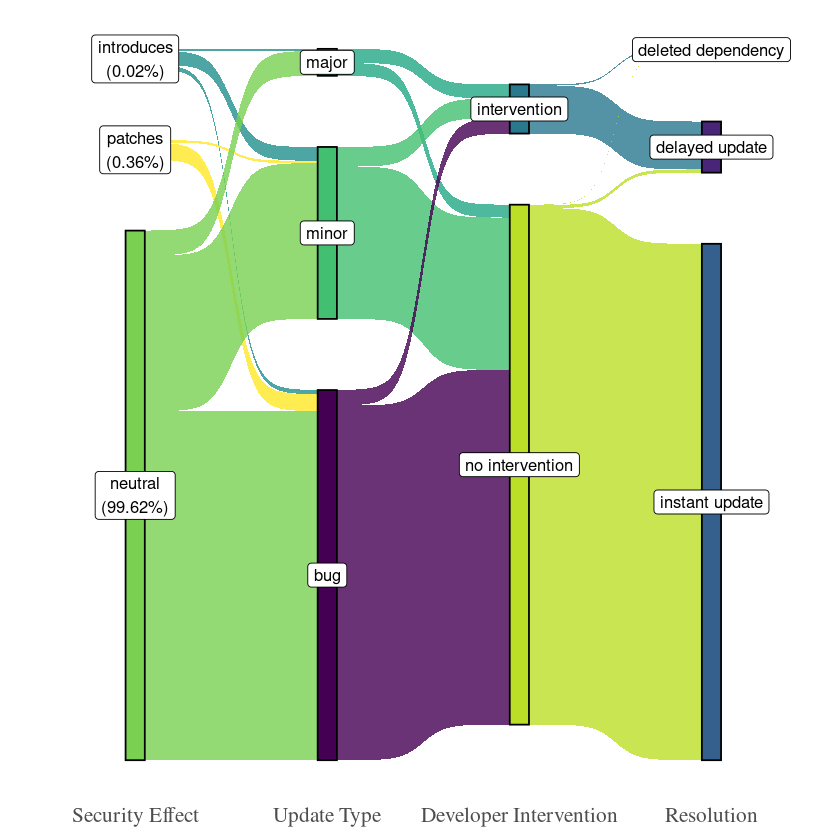

In [84]:
long_df %>% mutate(
    extra_lab = ifelse(node == "introduces", paste0("\n(", introduces_perc, ")"), ifelse(node == "patches", paste0("\n(", patches_perc, ")"), ifelse(node == "neutral", paste0("\n(", neutral_perc, ")"), "")))
) %>% ggplot( 
    aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        value = weight,
        label = paste0(node, extra_lab))) +
    geom_sankey(flow.alpha = 0.8, node.color = 1) +
    geom_sankey_label(size = 3.5, color = 1, fill = "white") +
    # geom_text()
    scale_fill_viridis_d() +
    theme_sankey(base_size = 16) +
    labs(x = NULL) + 
    theme(
        legend.position = "none",
        text = element_text(family = "Times", size=16),
    )

ggsave("plots/rq3/flow_analysis.pdf", width=8, height=6, units=c("in"))


In [27]:
clean_df %>% group_by(developer_intervention, resolution) %>% summarise(count = n()) %>% ungroup() %>% mutate(
    perc = 100 * count/sum(count)
)

`summarise()` has grouped output by 'developer_intervention'. You can override
using the `.groups` argument.


developer_intervention,resolution,count,perc
<fct>,<fct>,<int>,<dbl>
no intervention,instant update,90262,90.0917266
no intervention,delayed update,606,0.6048568
no intervention,deleted dependency,59,0.0588887
intervention,delayed update,9030,9.0129655
intervention,deleted dependency,232,0.2315623


In [29]:
clean_df %>% filter(resolution == "delayed update" & developer_intervention == "intervention") %>% group_by(update_type) %>% summarise(count = n()) %>% ungroup() %>% mutate(
    perc = 100 * count/sum(count)
)

update_type,count,perc
<fct>,<int>,<dbl>
bug,2855,31.61683
minor,3637,40.27685
major,2538,28.10631


In [26]:
clean_df %>% filter(update_type == "bug") %>% group_by(developer_intervention, resolution) %>% summarise(count = n()) %>% ungroup() %>% mutate(
    perc = 100 * count/sum(count)
)

`summarise()` has grouped output by 'developer_intervention'. You can override
using the `.groups` argument.


developer_intervention,resolution,count,perc
<fct>,<fct>,<int>,<dbl>
no intervention,instant update,63065,95.42146434
no intervention,delayed update,112,0.16946332
no intervention,deleted dependency,9,0.01361759
intervention,delayed update,2855,4.31980149
intervention,deleted dependency,50,0.07565327


In [30]:
clean_df %>% group_by(resolution) %>% summarise(count = n()) %>% ungroup() %>% mutate(
    perc = 100 * count/sum(count)
)

resolution,count,perc
<fct>,<int>,<dbl>
instant update,90262,90.091727
delayed update,9636,9.617822
deleted dependency,291,0.290451


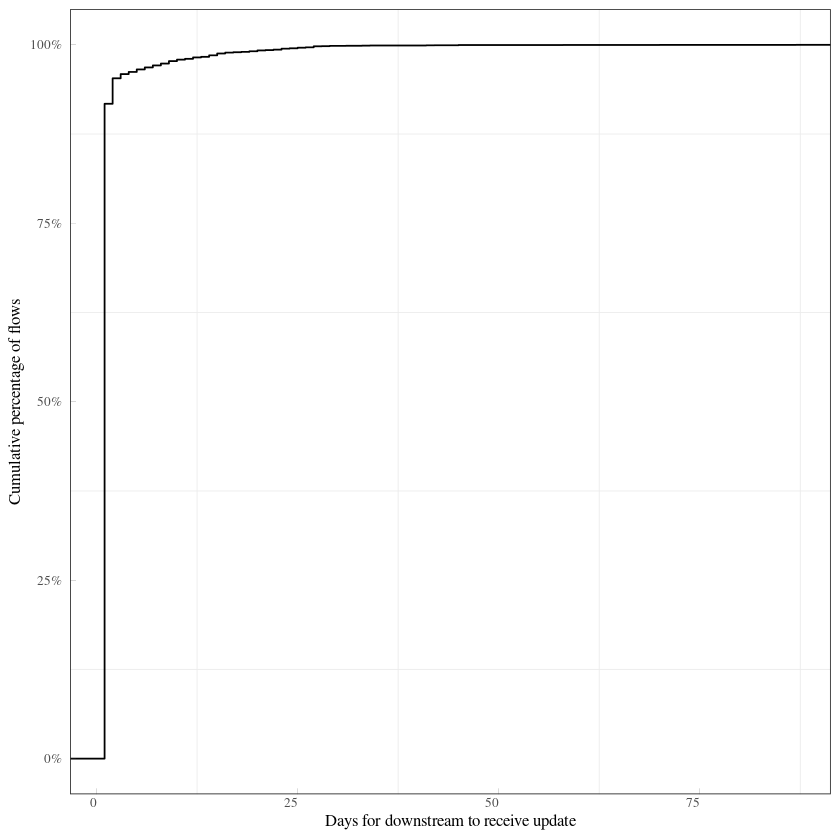

In [86]:
clean_df %>% 
    filter(resolution == "delayed update") %>%
        ggplot(aes(x = update_days)) + 
        stat_ecdf() +
        scale_y_continuous(labels = scales::percent) + 
        labs(x = "Days for downstream to receive update", y = "Cumulative percentage of flows") + 
        mytheme()

mysave("plots/rq3/delayed_update_days.pdf")